<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analysis-of-Public-Safety-Data" data-toc-modified-id="Analysis-of-Public-Safety-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analysis of Public Safety Data</a></span><ul class="toc-item"><li><span><a href="#Calls-for-Service" data-toc-modified-id="Calls-for-Service-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Calls for Service</a></span><ul class="toc-item"><li><span><a href="#Service-Calls-By-District" data-toc-modified-id="Service-Calls-By-District-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Service Calls By District</a></span></li><li><span><a href="#Service-Calls-By-Precinct" data-toc-modified-id="Service-Calls-By-Precinct-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Service Calls By Precinct</a></span></li><li><span><a href="#Service-Calls-By-Day" data-toc-modified-id="Service-Calls-By-Day-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Service Calls By Day</a></span></li><li><span><a href="#Service-Call-Reasons/Description" data-toc-modified-id="Service-Call-Reasons/Description-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Service Call Reasons/Description</a></span></li></ul></li></ul></li></ul></div>

# Analysis of Public Safety Data

## Calls for Service

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)

sys.path.insert(0, PWD)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "settings.py")

import django
django.setup()

from django.db.models import Count
from publicsafety import models

from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import csv
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import pysal as ps

init_notebook_mode(connected=True)

/usr/local/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning:

The `dill` module is required to use the sqlite backend fully.



### Service Calls By District

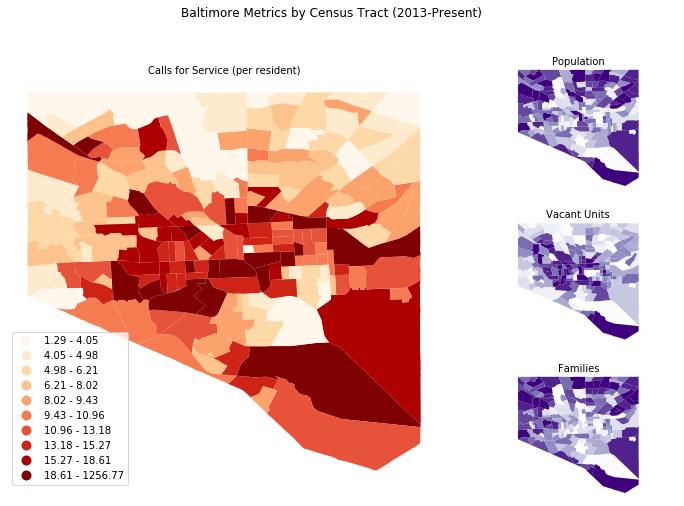

In [2]:
# Plot calls by location
%matplotlib inline

# See this link for how to populate data by location and colorize:
# http://darribas.org/gds15/content/labs/lab_03.html#Non-spatial-manipulations
calls_of_service = models.EmergencyPoliceCalls.objects \
    .values('census_tracts') \
    .order_by ('census_tracts') \
    .annotate(calls_for_service=Count('census_tracts'))
listed_calls_of_service = list(calls_of_service)

# retrieve shapefiles via via: python3 cli.py shapefiles
lsoas = gpd.read_file("./raw/geo_export_0495fbaf-7a72-435c-a794-143df7732406.shp")
lsoas['calls_for_service'] = 0

# Main figure - calls for service
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Baltimore Metrics by Census Tract (2013-Present)')
annotation_options = dict(xy=(0.5, 1), xycoords='axes fraction', ha='center')

ax = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
ax.annotate('Calls for Service (per resident)', **annotation_options)
ax.set_axis_off()
for count, element in enumerate(listed_calls_of_service):
    if element['census_tracts'] != '':
        index = lsoas.index[lsoas['name'] == element['census_tracts']].tolist()
        population = lsoas.iloc[index, lsoas.columns.get_loc('population')]
        lsoas.iloc[index, lsoas.columns.get_loc('calls_for_service')] = element['calls_for_service']/population
lsoas.plot(column='calls_for_service', ax=ax, cmap='OrRd', legend=True, k=10, scheme='quantiles',  legend_kwds={'loc': 'lower left'})

# Population figure, top right
ax2 = plt.subplot2grid((3, 3), (0, 2))
ax2.annotate('Population', **annotation_options)
ax2.set_axis_off()
lsoas.plot(column='population', ax=ax2, cmap='Purples', legend=False, k=10, scheme='quantiles',  legend_kwds={'loc': 'lower left'})

# Vacant units figure, middle right
ax3 = plt.subplot2grid((3, 3), (1, 2))
ax3.annotate('Vacant Units', **annotation_options)
ax3.set_axis_off()
lsoas.plot(column='vacant', ax=ax3, cmap='Purples', legend=False, k=10, scheme='quantiles',  legend_kwds={'loc': 'lower left'})

# No. of families figure, bottom right
ax4 = plt.subplot2grid((3, 3), (2, 2))
ax4.annotate('Families', **annotation_options)
ax4.set_axis_off()
lsoas.plot(column='families', ax=ax4, cmap='Purples', legend=False, k=10, scheme='quantiles',  legend_kwds={'loc': 'lower left'})

plt.axis('equal')
plt.show()

### Service Calls By Precinct

In [3]:
# Show relative share of calls handled by district

districts = models.EmergencyPoliceCalls.objects \
    .values('district') \
    .order_by ('district') \
    .annotate(events=Count('district'))
raw_districts = pd.DataFrame(districts).sort_values(by=['events'], ascending=False)

# Show relative share of calls handled by police post
police_posts = models.EmergencyPoliceCalls.objects \
    .values('police_post') \
    .order_by ('police_post') \
    .annotate(events=Count('police_post'))
raw_police_posts = pd.DataFrame(police_posts).sort_values(by=['events'], ascending=False)

figure_one = go.Bar(x=raw_districts.district, y=raw_districts.events, name="Service Calls By District")
figure_two = go.Scatter(x=raw_police_posts.police_post, y=raw_police_posts.events, mode="markers", name="Service Calls By Police Post", connectgaps=True)

combined_figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('Service Calls By District', 'Service Calls By Police Post'))
combined_figure.append_trace(figure_one, 1, 1)
combined_figure.append_trace(figure_two, 1, 2)

iplot(combined_figure)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Service Calls By Day

In [4]:
# Plot by time of day

calls_by_hour = models.EmergencyPoliceCalls.objects \
    .extra(select={'hour': 'date_part(\'hour\', \"call_date_time\")'}) \
    .values('hour') \
    .order_by('hour') \
    .annotate(Calls=Count('call_date_time'))

raw = pd.DataFrame(calls_by_hour).sort_values(by=['hour'], ascending=True)
figure_one = go.Bar(y=raw.hour,
                    x=raw.Calls, 
                    orientation='h',
                    name="Calls By Hour")

# Plot by dates (and moving average on a rolling period)

calls_by_day = models.EmergencyPoliceCalls.objects \
    .extra(select={'day': 'date( call_date_time )'}) \
    .values('day') \
    .order_by('day') \
    .annotate(call_count=Count('call_date_time'))

raw = pd.DataFrame(calls_by_day)
raw['MA'] = raw['call_count'].rolling(window=30).mean()

figure_two_one = go.Scatter(x=raw.day,
                            y=raw.call_count,
                            mode='lines',
                            name='Call Count')
figure_two_two = go.Scatter(x=raw.day,
                            y=raw.MA,
                            mode='lines',
                            name='Moving Average (30 Days)')

combined_figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('Call Count By Hour of Day', 'Call Count By Day'))
combined_figure.append_trace(figure_one, 1, 1)
combined_figure.append_trace(figure_two_one, 1, 2)
combined_figure.append_trace(figure_two_two, 1, 2)

iplot(combined_figure)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Service Call Reasons/Description

In [8]:
calls_with_hour_chosen = models.EmergencyPoliceCalls.objects \
    .extra(select={'hour': 'date_part(\'hour\', \"call_date_time\")'}) \
    .values('hour', 'description', 'gps_coordinates', 'census_tracts') \
    .order_by('?')[:120000] # random sample to avoid hours-long execution

descriptions = models.EmergencyPoliceCalls.objects \
    .values('description') \
    .annotate(event_count=Count('description')) \
    .order_by ('-event_count')

print("Approximately", len(descriptions), "unique descriptions provided for service calls")
# Text classification system used from this paper: 
# https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2017-42.pdf

"""
Note:

The first 100 unique descriptions by count end at a count of 75:

- 911/NO  VOICE - 628873
- DISORDERLY - 391491
- Traffic Stop - 369922
...
"""

descriptions_to_use = descriptions[:99]
approx_length = models.EmergencyPoliceCalls.objects.all().count()
approx_number_covered = sum([item['event_count'] for item in descriptions_to_use])
approx_percent_covered = approx_number_covered/approx_length

print('Approximately', str(int(approx_percent_covered*100)), 'percent covered by selecting the top', str(len(descriptions_to_use)))
# Uncomment this section to generate csv mapping manually after updating your mappings
"""
print("generating csv for re-classification")
with open('./raw/test.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow([item['description'] for item in descriptions[:100]])
"""
mappings = {}
with open('./docs/notebooks/911_Police_Calls_for_Service.csv') as f:
    reader=csv.reader(f, skipinitialspace=True, quotechar="'")
    for count, row in enumerate(reader):
        if count != 0:
            mappings[row[0]]=row[1]

for description in descriptions_to_use:
    description['category'] = mappings[description['description']]
    
raw = pd.DataFrame(descriptions_to_use)
raw = raw.append({
    'category': 'Uncategorized',
    'event_count': approx_length - approx_number_covered,
    'description': 'N/A'}, ignore_index=True)

for count, call in enumerate(calls_with_hour_chosen):
    call['category'] = mappings.get(call['description'], 'Uncategorized')
raw_hourly = pd.DataFrame(calls_with_hour_chosen)
raw_hourly = raw_hourly.groupby(['category','hour']).size().reset_index(name='event_count')

figure_one = go.Bar(x=raw.category,
                    y=raw.event_count,
                    name="Calls By Categorized Description")

combined_figure = tools.make_subplots(rows=1, cols=2, subplot_titles=("Calls By Categorized Description", "Calls By Cat. Desc. (By Time of Day)"))
combined_figure.append_trace(figure_one, 1, 1)

# create all traces for second plot
figure_labels = ['Traffic', 'No Voice', 'Disorderly Conduct', 'Assault', 'Other', 'Drugs and Alcohol', 'Check', 'Property', 'Fire', 'Uncategorized']
for label in figure_labels:
    figure_to_append = go.Scatter(x=raw_hourly.hour,
                            y=raw_hourly[raw_hourly['category'] == label].event_count,
                            mode='lines',
                            name=label,
                            line={'shape': 'spline', 'smoothing': 1.3})
    combined_figure.append_trace(figure_to_append, 1, 2)

iplot(combined_figure)
calls_with_census_tracts = pd.DataFrame(calls_with_hour_chosen).groupby(['category','census_tracts']).size().reset_index(name='event_count')
calls_with_census_tracts = pd.pivot_table(calls_with_census_tracts, values='event_count', index=['census_tracts'], columns=['category'], aggfunc=np.sum)\
    .sort_values('Assault', ascending=False)

cm = ListedColormap(sns.color_palette("coolwarm", 10))

calls_with_census_tracts.style.background_gradient(cmap=cm)

Approximately 14900 unique descriptions provided for service calls
Approximately 91 percent covered by selecting the top 99
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning:

invalid value encountered in less

